# EVENT BASED DPM ON SYNTHETIC DATASET - 5 BIOMARKERS

#### IMPORTING NECESSARY LIBRARIES

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import copy
import statistics
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

#### READING SYNTHETIC BIOMARKERS DATA

In [58]:
def synthetic_dataset(biomarkers = [i for i in range(1,11)]):
    data = pd.read_csv('Synthetic Data.csv')
    biomarkers = np.array(biomarkers)-1            
    data = data.iloc[:,list(biomarkers) + [-2]]
    return data

In [59]:
df = synthetic_dataset([1,2,3,4,5])
df.head()

,BM1,BM2,BM3,BM4,BM5,Condition Name
0,-0.692,-0.190,1.217,-1.142,0.082,CN
1,0.199,-0.238,-0.156,0.627,0.288,CN
2,-0.668,1.080,1.161,0.399,0.070,AD
3,1.091,-0.796,0.012,0.705,0.052,CN
4,1.195,2.981,4.020,2.057,3.439,AD


#### PLOTTING HISTOGRAM OF DIFFERENT BIOMARKER VALUES IN AD VS CN SUBPOPULATION

In [60]:
def biomarkers_distribution(data):
    biomarkers = data.shape[1]-1
    biomarker_names = data.columns[:biomarkers]  
    rows = biomarkers//2 + biomarkers%2
    columns = 2
    fig,ax = plt.subplots(rows,columns,figsize=(10,rows*3))
    for biomarker_number in range(len(biomarker_names)):
        ad_data = data[data['Condition Name']=='AD'].iloc[:,biomarker_number]
        cn_data = data[data['Condition Name']=='CN'].iloc[:,biomarker_number]
        ax[biomarker_number//2,biomarker_number%2].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','steelblue'])
        ax[biomarker_number//2,biomarker_number%2].set_title(biomarker_names[biomarker_number])
    if biomarkers%2==1:
        ax[rows-1,columns-1].set_axis_off()
    ax[0,0].legend()
    fig.tight_layout()

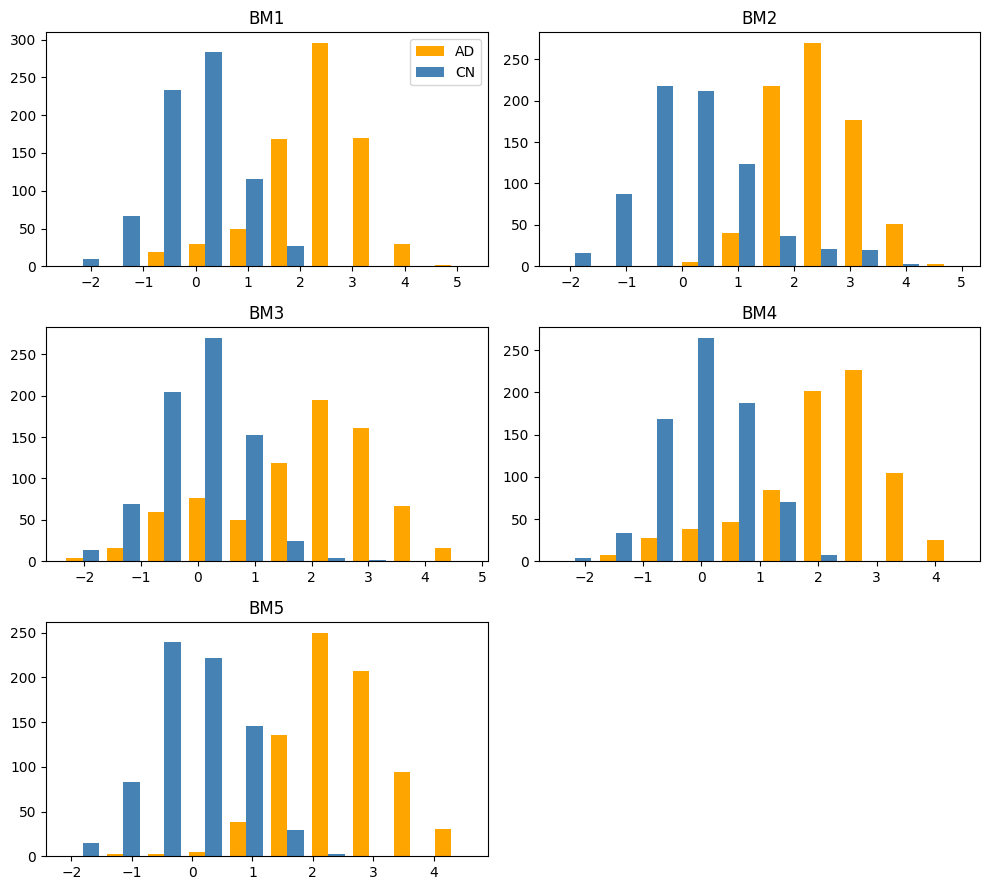

In [61]:
biomarkers_distribution(df)

#### FITTING GAUSSIAN MIXTURE MODELS USING EXPECTATION-MAXMIZATION ALGORITHM

In [62]:
def Gaussian_EM(dataframe,number_of_components=2,number_of_iterations = 500):

    X = dataframe.iloc[:,0]
    iteration_nums = []
    likelihood = []
    parameters = {}
    
    means = np.linspace(min(X),max(X),number_of_components)          # Means initialization
    stds = np.ones(number_of_components)                             # Standard deviation initialization   
    weights = np.full(number_of_components,1.0/number_of_components) # Mixing coefficients initialization

    for iteration in range(1,number_of_iterations):
        responsibility = []
        
        for i in range(number_of_components):
            responsibility.append(weights[i]*norm.pdf(X,means[i],stds[i]))
    
        norm_responsibility = np.array(responsibility)/np.sum(responsibility,axis=0)  # Normalized responsibility of each data point
        
        for i in range(number_of_components):
            weights[i] = np.mean(norm_responsibility[i])                                                       # Updating mixing coefficients
            means[i] = np.sum(norm_responsibility[i]*X)/np.sum(norm_responsibility[i])                         # Updating means   
            stds[i] = np.sqrt(np.sum(norm_responsibility[i]*(X - means[i])**2)/np.sum(norm_responsibility[i])) # Updating standard deviation

        # Log likelihood of complete data
        log_likelihood = np.sum(np.log(np.sum([weights[i]*norm.pdf(X,means[i],stds[i]) for i in range(number_of_components)],axis=0)))

        # Early stopping criteria
        if iteration>10 and np.array_equal(np.full(10,np.round(log_likelihood,2)),np.round(likelihood[-10:],2)):
            break
        else:
            likelihood.append(log_likelihood)
            iteration_nums.append(iteration)

    # Lower values correspond to CN and higher values correspond to AD
    # Finding corresponding components for AD and CN

    control_data = dataframe[dataframe['Condition Name']=='CN'].iloc[:,0]
    component_count = np.zeros(number_of_components)
    
    for value in control_data:
        p = weights*norm.pdf(value,means,stds)
        component_count[np.argmax(p)]+=1

    control_component = np.argmax(component_count)
    parameters['Control Component'] = [weights[control_component],means[control_component],stds[control_component]]
    patient_components = []
    for index in range(len(weights)):
        if index!=control_component:
            patient_components.append([weights[index],means[index],stds[index]])
    parameters['Patient Components'] = patient_components
    return parameters,log_likelihood

#### CHOOSING THE BEST MIXTURE MODEL USING BIC 

In [63]:
def best_model(dataframe):
    best_parameters = {}
    best_bic = 1e10
    for component_count in range(3,6):
        parameters,log_likelihood = Gaussian_EM(dataframe,component_count)
        bic_value = -2*log_likelihood + component_count*3*np.log(len(dataframe))
        if bic_value<best_bic:
            best_bic=bic_value
            best_parameters=parameters
    return best_parameters

#### MIXTURE MODEL PROBABILITY DENSITY

In [64]:
def mixture_model_probability(value,parameters):
    probability = 0
    for component in parameters:
        probability+=component[0]*norm.pdf(value, component[1],component[2])
    return probability

#### DENSITY ESTIMATION USING EM

In [65]:
def density_estimation(data):
    biomarkers = data.shape[1]-1
    biomarker_names = data.columns[:biomarkers]
    number_of_biomarkers = len(biomarker_names)
    
    rows = biomarkers//2 + biomarkers%2
    columns = 2
    fig,ax = plt.subplots(rows,columns,figsize=(10,rows*3))
    gmm_parameters = {}

    for biomarker_number in range(number_of_biomarkers):
        
        biomarker_data = data.iloc[:,[biomarker_number,-1]]
        parameters = best_model(biomarker_data)
    
        # Plotting original Data with labels
        
        ad_data = data[data['Condition Name']=='AD'].iloc[:,biomarker_number]
        cn_data = data[data['Condition Name']=='CN'].iloc[:,biomarker_number]
        x_index,y_index = biomarker_number//2,biomarker_number%2
        ax[x_index,y_index].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','steelblue'],density=True,bins=10)
        gmm_parameters[biomarker_names[biomarker_number]] = parameters
        control_parameters = parameters['Control Component']
        patient_parameters = parameters['Patient Components']
    
        # Fitted GMM model
        
        X_sorted = np.sort(biomarker_data.iloc[:,0])
        cn_density_estimation = control_parameters[0]*norm.pdf(X_sorted, control_parameters[1],control_parameters[2])
        ad_density_estimation = np.zeros(len(X_sorted))
        for component in patient_parameters:
            ad_density_estimation = ad_density_estimation + component[0]*norm.pdf(X_sorted, component[1],component[2])
        density_estimation = (cn_density_estimation + ad_density_estimation)
        
        ax[x_index,y_index].plot(X_sorted,cn_density_estimation*2, color='steelblue', linewidth=2)
        ax[x_index,y_index].plot(X_sorted,ad_density_estimation*2, color='orange', linewidth=2)
        ax[x_index,y_index].set_title(biomarker_names[biomarker_number])

    if biomarkers%2==1:
        ax[rows-1,columns-1].set_axis_off()

    ax[0,0].legend()
    fig.tight_layout()
    return gmm_parameters

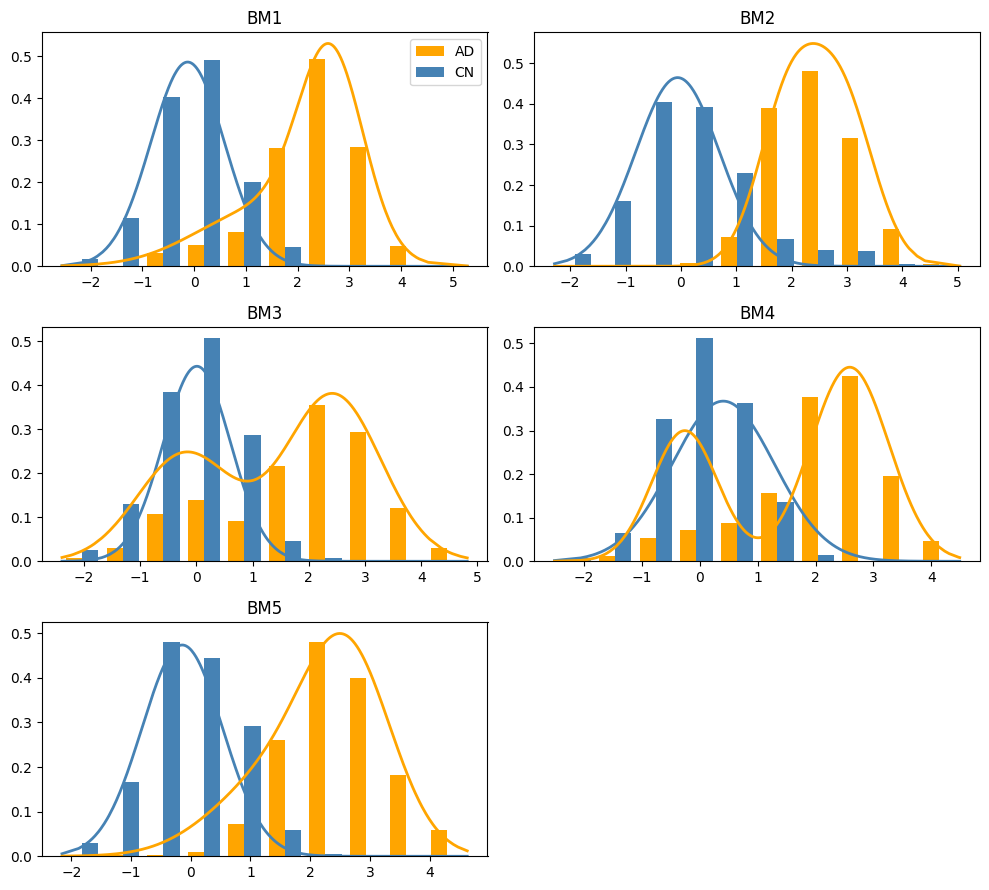

In [66]:
gmm_parameters = density_estimation(df)

In [67]:
gmm_parameters

{'BM1': {'Control Component': [0.4341794906067668,
   -0.12547009825721694,
   0.7117669357283004],
  'Patient Components': [[0.2061323983079305,
    1.2813771839299,
    1.2335539668792315],
   [0.35968811108530274, 2.6426798532550677, 0.6285149750223135]]},
 'BM2': {'Control Component': [0.44083673906756354,
   -0.05927087162104233,
   0.756912670524341],
  'Patient Components': [[0.2739234375753358,
    1.9527495678483975,
    0.5538752068212699],
   [0.2852398233571007, 2.917410199918633, 0.5760923106203849]]},
 'BM3': {'Control Component': [0.3332777496305961,
   0.0075445478775960605,
   0.6002459601258364],
  'Patient Components': [[0.2601904790359144,
    -0.19996245784455877,
    0.8475862917287285],
   [0.4065317713334895, 2.4294072462058582, 0.8548314804972934]]},
 'BM4': {'Control Component': [0.4084292760597391,
   0.4039460533012508,
   0.8868621070700251],
  'Patient Components': [[0.21432994419576237,
    -0.2615699547925952,
    0.5705788610036204],
   [0.3772407797444

#### DEFINING LIKELIHOOD FUNCTION

In [74]:
def patient_likelihood_at_K(individual_data,event_sequence,K,gmm_parameters):

    ''' If a patient is at the position K in the progression model,
        where events upto K have occured and rest have not'''

    likelihood = 1

    for event in range(K+1):
        parameters = gmm_parameters[event_sequence[event]]['Patient Components']
        biomarker_value = individual_data[event]
        likelihood*=mixture_model_probability(biomarker_value,parameters)

    for event in range(K+1,len(event_sequence)):
        parameters = gmm_parameters[event_sequence[event]]['Control Component']
        biomarker_value = individual_data[event]
        likelihood*=norm.pdf(biomarker_value,parameters[1],parameters[2])

    return likelihood
    
def patient_likelihood(individual_data,event_sequence,gmm_parameters):

    ''' Integrating out the hidden variable K '''
    
    individual_data_likelihood=0
    uniform_prior = 1.0/len(event_sequence)
    for event in range(-1,len(event_sequence)):
        likelihood_at_k = patient_likelihood_at_K(individual_data,event_sequence,event,gmm_parameters)
        individual_data_likelihood+=likelihood_at_k
    return np.log(uniform_prior*individual_data_likelihood)

def data_likelihood(patients_data,biomarker_names,event_sequence,gmm_parameters):
    
    patients_data = np.reshape(patients_data,(-1, len(biomarker_names)))
    rows = patients_data.shape[0]
    columns = patients_data.shape[1]
    data_likelihood = 0
    
    for patient_number in range(rows):
        individual_data = patients_data[patient_number]
        data_likelihood+=patient_likelihood(individual_data,event_sequence,gmm_parameters)
    
    return data_likelihood

#### GREEDY ASCENT ALGORITHM

In [75]:
def greedy_ascent(dataframe,biomarker_names,gmm_parameters,iterations=100,n_initial=5):
    
    sequences = []
    likelihoods = []
    
    for n in range(n_initial):
        likelihood = []

        # Initializing a random sequence
        sequence = copy.deepcopy(biomarker_names)
        random.shuffle(sequence)
        sorted_data = dataframe[sequence]
        data = sorted_data.to_numpy()
        ml_likelihood = data_likelihood(data,biomarker_names,sequence,gmm_parameters)
        
        for iteration_number in tqdm(range(iterations)):

            # Generating new sequence and checking the likelihood 
            new_sequence = copy.deepcopy(sequence)
            index_1, index_2 = random.sample(range(len(sequence)), 2)
            new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1]
            sorted_data = dataframe[new_sequence]
            data = sorted_data.to_numpy()
            new_likelihood = data_likelihood(data,biomarker_names,new_sequence,gmm_parameters)
            
            if new_likelihood>ml_likelihood:
                ml_likelihood=new_likelihood
                sequence=new_sequence
                
            likelihood.append(ml_likelihood)
        
        sequences.append(sequence)
        likelihoods.append(likelihood)

    max_count=0
    for sequence in sequences:
        count = sequences.count(sequence)
        if count>max_count:
            max_count = count
            most_probable_sequence = sequence

    for values in likelihoods:
        plt.plot(values)
    plt.show()
    
    return most_probable_sequence

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [41:42<00:00, 125.15s/it]


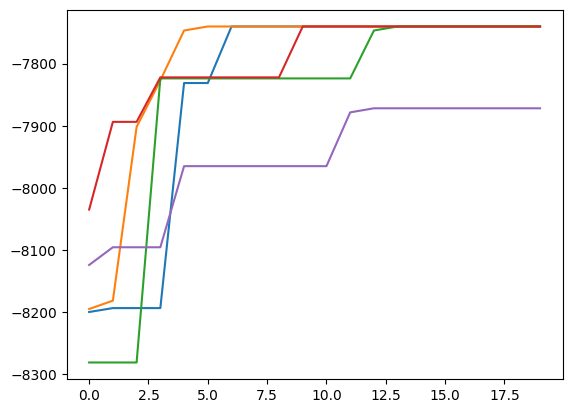

In [76]:
ad_data = df[df['Condition Name']=='AD'].iloc[:,:-1].reset_index(drop=True)
biomarker_names = list(ad_data.columns)
ml_sequence = greedy_ascent(ad_data,biomarker_names,gmm_parameters,20,5)

In [12]:
print('Maximum Likelihood Sequence:',ml_sequence)

Maximum Likelihood Sequence: ['BM2', 'BM5', 'BM1', 'BM4', 'BM3']


#### MARKOV CHAIN MONTE CARLO ALGORITHM

In [13]:
def mcmc(dataframe,biomarker_names,gmm_parameters,ml_sequence,iterations=100):

    # Starting with maximum likelihood sequence found previously
    current_sequence = copy.deepcopy(ml_sequence)
    sorted_data = dataframe[current_sequence]
    data = sorted_data.to_numpy()
    current_likelihood = data_likelihood(data,biomarker_names,current_sequence,gmm_parameters)
    
    final_sequences = []
    
    for iteration_number in tqdm(range(iterations)):
        
        #Generating new sequence and checking the likelihood 
        new_sequence = copy.deepcopy(current_sequence)
        index_1, index_2 = random.sample(range(len(new_sequence)), 2)
        new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1]
        sorted_data = dataframe[new_sequence]
        data = sorted_data.to_numpy()
        new_likelihood = data_likelihood(data,biomarker_names,new_sequence,gmm_parameters)
        check = np.exp(new_likelihood - current_likelihood)
        if random.random()<=check:
            current_sequence=new_sequence
            current_likelihood=new_likelihood
        final_sequences.append(current_sequence)
        
    return final_sequences

In [14]:
mcmc_samples = mcmc(ad_data,biomarker_names,gmm_parameters,ml_sequence,iterations=5000)

100%|███████████████████████████████████████| 5000/5000 [08:13<00:00, 10.13it/s]


#### POSITIONAL VARIANCE DIAGRAM

In [15]:
def positional_variance_diagram(data,sequences):
    
    # Removing warm-up iterations
    burn_in_period = int(0.2*len(sequences))
    sequences = sequences[burn_in_period:]
    
    events = [number for number in range(1,data.shape[1]+1)]
    transposed = np.array(sequences).T
    most_probable_sequence = [str(statistics.mode(x)) for x in transposed]
    confusion_matrix_values = np.zeros((len(events),len(events)))
    for column in range(len(events)):
        for row in range(len(events)):
            biomarker = most_probable_sequence[row]
            count = np.sum(transposed[column]==biomarker)
            confusion_matrix_values[row][column]=count
    
    fig, ax = plt.subplots()
    
    ax.matshow(confusion_matrix_values, cmap=plt.cm.Purples)
    ticks_position = np.array(events)-1
    ax.set_xticks(ticks_position,events)
    ax.set_yticks(ticks_position,most_probable_sequence) 
    ax.set_ylabel('Biomarker Name', fontsize=15)
    ax.set_xlabel('Event Order', fontsize=15)

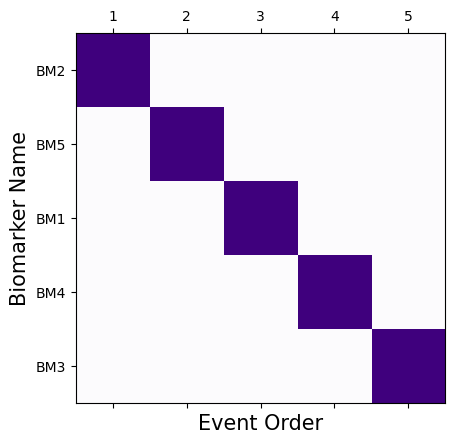

In [16]:
positional_variance_diagram(ad_data,mcmc_samples)

### PATIENT STAGING USING FITTED EBM

In [17]:
def patient_staging(data,biomarker_names,probable_sequence,gmm_parameters):
    controls = np.zeros(len(biomarker_names)+1)
    patients = np.zeros(len(biomarker_names)+1)
    stages = np.linspace(0,len(biomarker_names),len(biomarker_names)+1)

    control_data = df[df['Condition']==0].iloc[:,:-2].reset_index(drop=True)
    control_data = np.reshape(control_data,(-1, len(biomarker_names)))
    
    patient_data = df[df['Condition']==1].iloc[:,:-2].reset_index(drop=True)
    patient_data = np.reshape(patient_data,(-1, len(biomarker_names)))


    for control_number in range(control_data.shape[0]):
        
        individual_data = control_data[control_number]
        likelihood=-np.inf
        p_event = -2

        for event in range(-1,len(probable_sequence)):
            likelihood_at_k = patient_likelihood_at_K(individual_data,probable_sequence,event,gmm_parameters)
            if likelihood_at_k>=likelihood:
                likelihood=likelihood_at_k
                p_event=event

        controls[p_event+1]+=1

    for patient_number in range(patient_data.shape[0]):

        individual_data = patient_data[patient_number]
        likelihood=-np.inf
        p_event = -2

        for event in range(-1,len(probable_sequence)):
            likelihood_at_k = patient_likelihood_at_K(individual_data,probable_sequence,event,gmm_parameters)
            if likelihood_at_k>likelihood:
                likelihood=likelihood_at_k
                p_event=event

        patients[p_event+1]+=1

    controls = controls/np.sum(controls)
    patients = patients/np.sum(patients)

    width = 0.4

    plt.figure(figsize=(10, 6))
    plt.bar(stages-0.2,controls,width,color='steelblue')
    plt.bar(stages+0.2,patients,width,color='orange')
    plt.xlabel("EBM Stage")
    plt.xticks(stages)
    plt.ylabel("Fraction")
    plt.legend(["Controls", "Patients"])
    plt.tight_layout() 
    plt.show()

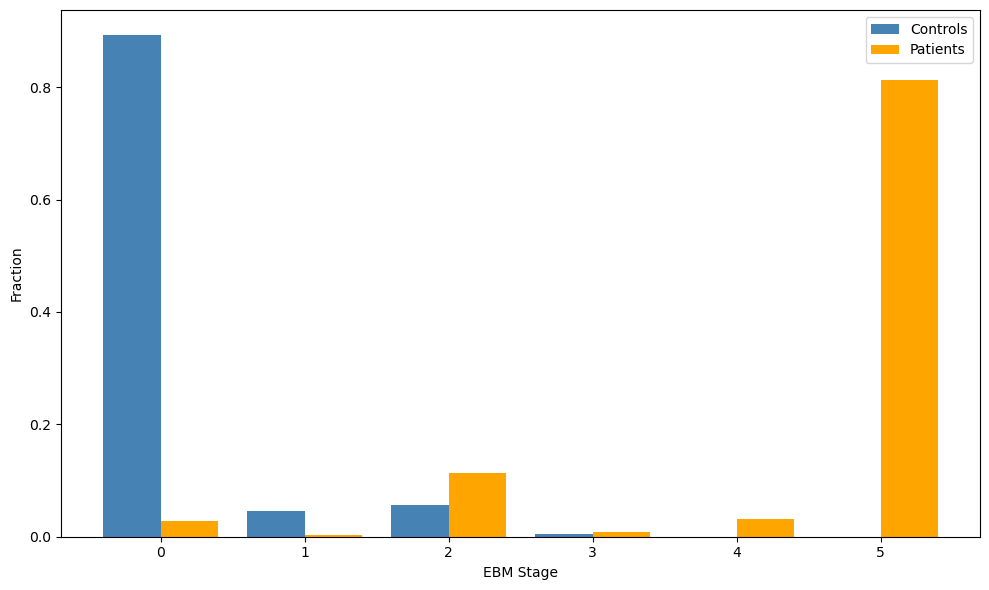

In [18]:
patient_staging(df,biomarker_names,mcmc_samples[-1],gmm_parameters)